### Time Series Forecasting: Total Production Forecasting

---
Raúl Arrabales Moreno (Jun. 2023)

---

### Contents
- 0.- **Setup** (*Config and dataset loading*)
- 1.- **Autoregressive (univariate) TS Forecasting** (*ARIMA and AutoARIMA baseline models*)
- 2.- **Multivariate TS Forecasting** (*Fb Prophet*)

## Setup

### Libs

In [1]:
# dataset manipulation
import pandas as pd 
import numpy as np

# date handling
import datetime
from datetime import date, timedelta

# visualizations 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns
from sktime.utils import plotting
from sktime.utils.plotting import plot_series

# sktime
import sktime

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split

from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.naive import NaiveForecaster

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

### TS Dataset Loading

In [2]:
# Time Series data from: https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data 
ts_file_path = 'data/DailyDelhiClimateTrain.csv'
ts_df = pd.read_csv(ts_file_path)

# check
ts_df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


In [3]:
# Set date as index
ts_df.set_index(pd.DatetimeIndex(ts_df['date']), inplace=True)

In [4]:
ts_df.head(4)

,date,meantemp,humidity,wind_speed,meanpressure
date,,,,,
2013-01-01,2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,2013-01-04,8.666667,71.333333,1.233333,1017.166667


## Autoregressive (univariate) TS Forecasting
Try ARIMA and AutoARIMA as baseline reference models.<br>
(not taking into account meteorological data or any other vble.

### Backtesting partition

In [5]:
# Using humidity as the targe vble
y = ts_df['humidity']
y_train, y_test = temporal_train_test_split(y)

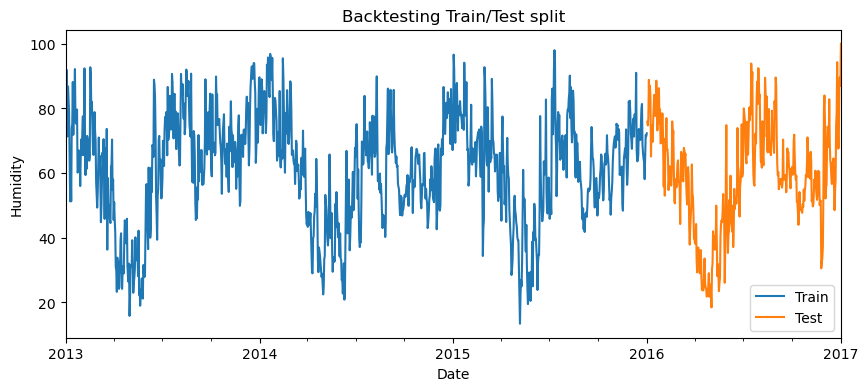

In [6]:
# Train/Test viz
plt.figure(figsize=(10,4))
y_train.plot(label='Train')
y_test.plot(label='Test')
plt.title('Backtesting Train/Test split')
plt.xlabel("Date")
plt.ylabel("Humidity")
plt.legend()

In [7]:
# Establish the forecast distance same as test 
fh = ForecastingHorizon(y_test.index, is_relative=False)

### ARIMA 
Baseline model for comparison<br>
https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average 

In [8]:
"""
See https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.arima.ARIMA.html 
for details of ARIMA params
"""
forecasterARIMA = ARIMA(  
    order=(1, 0, 0),
    seasonal_order=(0, 0, 0, 0),
    suppress_warnings=True)

In [9]:
# Train
forecasterARIMA.fit(y_train)

ARIMA(suppress_warnings=True)

In [10]:
# Predict
y_pred = forecasterARIMA.predict(fh)

In [11]:
# Error
mape = mean_absolute_percentage_error(y_test, y_pred, symmetric=False)
mae = mean_absolute_error(y_test, y_pred, symmetric=False)
mase = mean_absolute_scaled_error(y_test, y_pred, y_train=y_train)
print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape:.2f}')
print(f'MASE: {mase:.2f}')

MAE: 13.00
MAPE: 0.30
MASE: 2.07


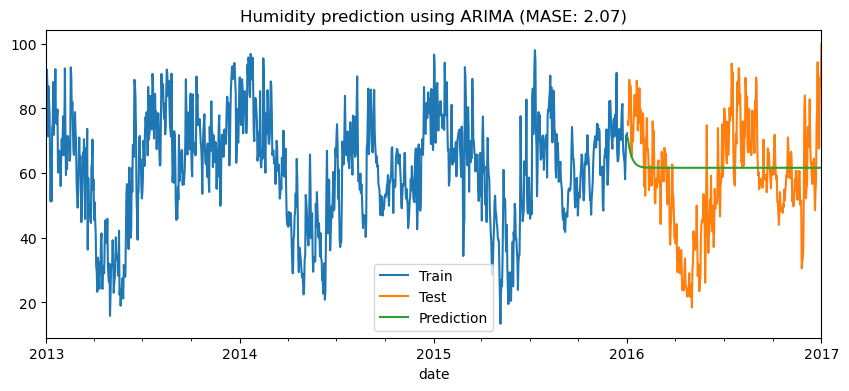

In [12]:
# Prediction visualization
plt.figure(figsize=(10,4))
plt.title(f'Humidity prediction using ARIMA (MASE: {mase:.2f})')
y_train.plot(label='Train')
y_test.plot(label='Test')
y_pred.plot(label='Prediction')
plt.legend()

### AutoARIMA
Baseline model for comparison<br>
https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.arima.AutoARIMA.html 

In [13]:
forecasterAutoARIMA = AutoARIMA(sp=1, d=0, max_p=2, max_q=2, suppress_warnings=True)  

In [14]:
# Train the forecaster
forecasterAutoARIMA.fit(y_train)

AutoARIMA(d=0, max_p=2, max_q=2, suppress_warnings=True)

In [15]:
# Get predictions
y_pred = forecasterAutoARIMA.predict(fh)

In [16]:
# Error
mape = mean_absolute_percentage_error(y_test, y_pred, symmetric=False)
mae = mean_absolute_error(y_test, y_pred, symmetric=False)
mase = mean_absolute_scaled_error(y_test, y_pred, y_train=y_train)
print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape:.2f}')
print(f'MASE: {mase:.2f}')

MAE: 13.16
MAPE: 0.31
MASE: 2.10


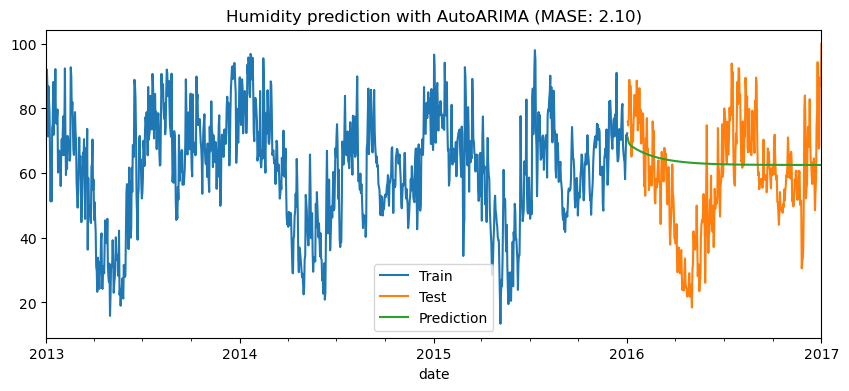

In [17]:
# Train/Test/Predictions viz
plt.figure(figsize=(10,4))
plt.title(f'Humidity prediction with AutoARIMA (MASE: {mase:.2f})')
y_train.plot(label='Train')
y_test.plot(label='Test')
y_pred.plot(label='Prediction')
plt.legend()

## Multivariate TS Forecasting with exogenous variables
Going directly to FB Prophet (expecting one of the best performances)<br>
https://facebook.github.io/prophet/

### Prophet
https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.fbprophet.Prophet.html 

In [20]:
# We keep humidity as the target and the other meteo vbles as X
feat_cols = ['meantemp', 'wind_speed', 'meanpressure']

In [21]:
y_test = y_test.asfreq('d')

# Feature vectors
X = ts_df[feat_cols]
X = X.asfreq('d')

In [22]:
# Forecast on test
fh = ForecastingHorizon(y_test.index, is_relative=False)

In [23]:
forecasterProphet = Prophet(
    n_changepoints=int(len(y_train) / 4),
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
)

In [24]:
forecasterProphet.fit(y_train)

16:13:12 - cmdstanpy - INFO - Chain [1] start processing
16:13:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet(daily_seasonality=False, n_changepoints=274, weekly_seasonality=False,
        yearly_seasonality=True)

In [25]:
# Make predictions
y_pred = forecasterProphet.predict(fh.to_relative(cutoff=y_train.index[-1]))
y_pred.index = y_test.index

In [26]:
# Error
mape = mean_absolute_percentage_error(y_test, y_pred, symmetric=False)
mae = mean_absolute_error(y_test, y_pred, symmetric=False)
mase = mean_absolute_scaled_error(y_test, y_pred, y_train=y_train)
print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape:.2f}')

MAE: 8.88
MAPE: 0.18


Text(0.5, 1.0, 'Humidity forecasting with Prophet (MAPE:0.18; MAE: 8.88)')

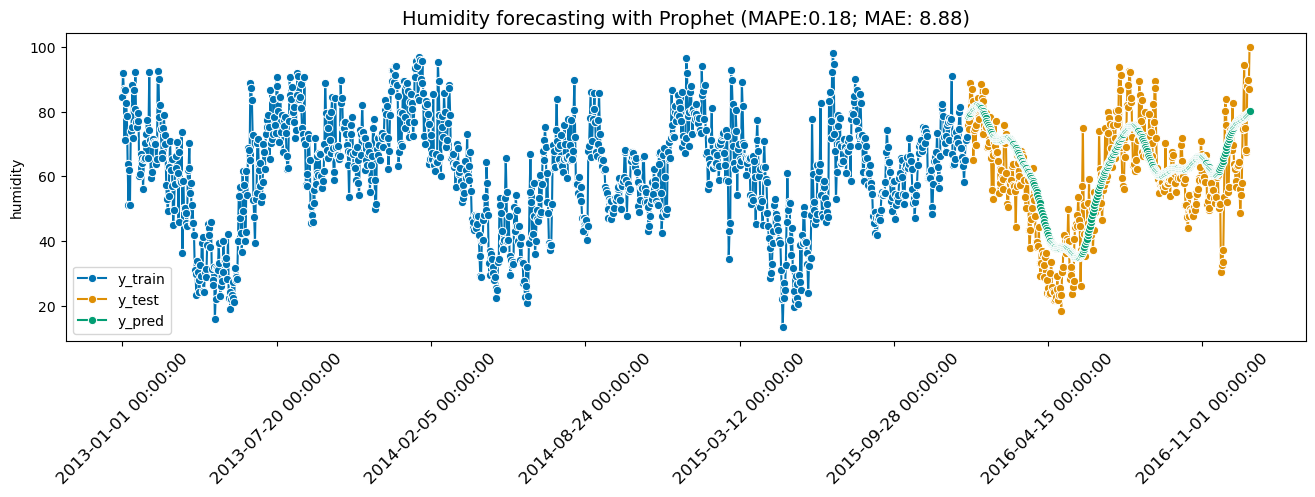

In [27]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mape = mean_absolute_percentage_error(y_test, y_pred, symmetric=False)
mae = mean_absolute_error(y_test, y_pred, symmetric=False)
plt.xticks(rotation=45)
plt.xticks(fontsize=12)
plt.title(f'Humidity forecasting with Prophet (MAPE:{mape:.2f}; MAE: {mae:.2f})', fontsize=14)

- Pending to test performance decay as a function of forecast distance. 
- Pending to build interval predictions
- Pending parameter tuning (ForecastingGridSearchCV)
- Pending forecaster deployment with MLFlow (https://www.sktime.net/en/latest/api_reference/deployment.html)